In [9]:
import os
import re
import random
import requests
import pandas as pd
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import logging


import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.update(["The", "I"]) 

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger(__name__)

BASE_URL = "https://www.gutenberg.org"

def get_bookshelves():
    """
    Fetches all bookshelves (genres) from Project Gutenberg.
    """
    response = requests.get(f"{BASE_URL}/ebooks/bookshelf/")
    if response.status_code != 200:
        raise Exception("Failed to fetch the bookshelves page.")

    soup = BeautifulSoup(response.text, 'html.parser')
    bookshelves = {}
    for link in soup.find_all("a", href=True):
        if "/ebooks/bookshelf/" in link['href']:
            genre_name = link.text.strip()
            genre_url = BASE_URL + link['href']
            bookshelves[genre_name] = genre_url

    logger.info(f"Found {len(bookshelves)} bookshelves.")
    return bookshelves

def fetch_books_from_shelf(shelf_url, output_folder, num_books,genre_name=None):
    """
    Fetches books from a specific bookshelf URL, removes non-English books, 
    and cleans the title to exclude download numbers or extra details.
    """
    response = requests.get(shelf_url)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch books from bookshelf: {shelf_url}")

    soup = BeautifulSoup(response.text, 'html.parser')
    book_links = []
    seen_urls = set()

    # Extract book links
    for link in soup.find_all("a", href=True):
        if link['href'].startswith("/ebooks/") and link['href'].split("/")[-1].isdigit():
            full_url = f"{BASE_URL}{link['href']}.txt.utf-8"
            if full_url not in seen_urls:
                seen_urls.add(full_url)
                raw_title = link.text.strip()
                
                # Remove downloads information and filter non-English books
                if "(French)" in raw_title or "(German)" in raw_title or "(Spanish)" in raw_title:
                    logger.info(f"Skipping non-English book: {raw_title}")
                    continue

                # Clean title to remove extra details like downloads
                sanitized_title = re.sub(r"\s*\d+\s*downloads$", "", raw_title).strip()
                sanitized_title = re.sub(r'[\\/*?:"<>|]', "_", sanitized_title)
                sanitized_title = re.sub(r'\s+', ' ', sanitized_title).strip()  # Remove extra spaces
                
                book_links.append({
                    "title": sanitized_title,
                    "url": full_url
                })

    logger.info(f"Found {len(book_links)} books in the selected bookshelf.")
    if len(book_links) == 0:
        logger.warning("No books found in this bookshelf.")
        return []

    # Select a limited number of books
    selected_books = random.sample(book_links, min(num_books, len(book_links)))

    # Prepare output folder
    os.makedirs(output_folder, exist_ok=True)
    raw_folder = os.path.join(output_folder, "raw")
    os.makedirs(raw_folder, exist_ok=True)

    metadata = []
    for book in selected_books:
        title = book["title"]
        raw_file_path = os.path.join(raw_folder, f"{title}.txt")
        if download_gutenberg_text(book["url"], raw_file_path):
            metadata.append({"title": book["title"], "url": book["url"], "genre": genre_name})

    # Save metadata
    if metadata:
        metadata_df = pd.DataFrame(metadata)
        metadata_df.to_csv(os.path.join(output_folder, "metadata.csv"), index=False)
        logger.info(f"Metadata saved to {output_folder}/metadata.csv")
    return metadata



def download_gutenberg_text(url, save_path):
    """
    Downloads text from a Project Gutenberg URL and saves it locally.
    """
    response = requests.get(url)
    if response.status_code == 200:
        with open(save_path, 'w', encoding='utf-8') as file:
            file.write(response.text)
        logger.info(f"Downloaded: {save_path}")
        return True
    else:
        logger.error(f"Failed to download: {url}")
        return False

def preprocess_books(raw_folder, clean_folder):
    """
    Preprocesses all raw text files: cleans the text and extracts linguistic features.
    """
    os.makedirs(clean_folder, exist_ok=True)
    features = []

    for file_name in os.listdir(raw_folder):
        if not file_name.endswith(".txt"):
            continue

        raw_file_path = os.path.join(raw_folder, file_name)
        with open(raw_file_path, 'r', encoding='utf-8') as raw_file:
            raw_text = raw_file.read()

        # Clean text
        cleaned_text = clean_text(raw_text)
        clean_file_path = os.path.join(clean_folder, file_name)
        with open(clean_file_path, 'w', encoding='utf-8') as clean_file:
            clean_file.write(cleaned_text)
        
        # Extract linguistic features
        tokens = word_tokenize(cleaned_text)
        sentences = sent_tokenize(cleaned_text)
        word_freq = Counter(tokens)
        vocab_richness = len(set(tokens)) / len(tokens) if tokens else 0
        avg_sentence_length = sum(len(word_tokenize(s)) for s in sentences) / len(sentences) if sentences else 0

        # Store features
        
#Get the list of English stopwords
        filtered_word_freq = Counter({word: freq for word, freq in word_freq.items() if word.isalpha() and word not in stop_words})
        features.append({
            "file_name": file_name,
            "vocab_richness": vocab_richness,
            "avg_sentence_length": avg_sentence_length,
            "num_sentences": len(sentences),
            "num_words": len(tokens),
            "most_common_word": filtered_word_freq.most_common(1)[0][0] if word_freq else None
        })
        logger.info(f"Processed: {file_name}")

    # Save features to CSV
    if features:
        features_df = pd.DataFrame(features)
        features_df.to_csv(os.path.join(clean_folder, "linguistic_features.csv"), index=False)
        logger.info(f"Linguistic features saved to {clean_folder}/linguistic_features.csv")
    else:
        logger.warning("No features extracted; the dataset might be empty.")

def clean_text(text):
    """
    Cleans the raw text by removing headers, footers, and extra spaces.
    """
    text = re.sub(r"\s+", " ", text)  # Remove extra whitespace
    start_index = text.find("*** START OF THE PROJECT GUTENBERG EBOOK")
    end_index = text.find("*** END OF THE PROJECT GUTENBERG EBOOK")
    if start_index != -1 and end_index != -1:
        text = text[start_index + len("*** START OF THE PROJECT GUTENBERG EBOOK"):end_index]
    return text.strip()
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.update(["The", "I"])
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

    


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Yanzheng\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yanzheng\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Yanzheng\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yanzheng\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
if __name__ == "__main__":
    # Get bookshelves
    bookshelves = get_bookshelves()

    # Choose genres to process
    selected_genres = ["Science Fiction", "Fantasy", "Mystery Fiction","Historical Fiction","Philosophy"]
    output_folder = "gutenberg_bookshelf_data"

    for genre in selected_genres:
        if genre in bookshelves:
            logger.info(f"Processing genre: {genre}")
            shelf_url = bookshelves[genre]
            genre_folder = os.path.join(output_folder, genre.replace(" ", "_"))
            """chang the number of download here"""
            metadata = fetch_books_from_shelf(shelf_url, genre_folder, num_books=30,genre_name=genre)
            if metadata:
                preprocess_books(os.path.join(genre_folder, "raw"), os.path.join(genre_folder, "cleaned"))


# Read and preprocess all books
book_texts = []
book_titles = []
base_dir = 'gutenberg_bookshelf_data'
for genre_folder in os.listdir(base_dir):
    genre_path = os.path.join(base_dir, genre_folder, 'cleaned')
    if not os.path.exists(genre_path):  #Skip if 'cleaned' folder not exist
        continue
    for filename in os.listdir(genre_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(genre_path, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read()
                preprocessed_text = preprocess_text(text)
                book_texts.append(preprocessed_text)
                book_titles.append(f"{genre_folder}: {filename.replace('.txt', '')}")  # Include genre in the title
    
print(f"Processed texts: {book_titles}")

2024-12-05 21:54:32,052 - Found 404 bookshelves.
2024-12-05 21:54:32,053 - Processing genre: Science Fiction
2024-12-05 21:54:32,239 - Skipping non-English book: Voyage au Centre de la Terre (French)
Jules Verne
1526 downloads
2024-12-05 21:54:32,240 - Skipping non-English book: L'île mystérieuse (French)
Jules Verne
1423 downloads
2024-12-05 21:54:32,241 - Found 23 books in the selected bookshelf.
2024-12-05 21:54:32,614 - Downloaded: gutenberg_bookshelf_data\Science_Fiction\raw\The Time Machine H. G. Wells.txt
2024-12-05 21:54:33,166 - Downloaded: gutenberg_bookshelf_data\Science_Fiction\raw\Twenty Thousand Leagues Under the Seas_ An Underwater Tour of the World Jules Verne.txt
2024-12-05 21:54:33,426 - Failed to download: https://www.gutenberg.org/ebooks/20000.txt.utf-8
2024-12-05 21:54:33,955 - Downloaded: gutenberg_bookshelf_data\Science_Fiction\raw\The Mysterious Island Jules Verne.txt
2024-12-05 21:54:34,395 - Downloaded: gutenberg_bookshelf_data\Science_Fiction\raw\Twenty Thous

Processed texts: ['Fantasy: Dorothy and the Wizard in Oz L. Frank Baum', 'Fantasy: Four Arthurian Romances active 12th century de Troyes Chrétien', 'Fantasy: Irish Fairy Tales James Stephens', "Fantasy: Le Morte d'Arthur_ Volume 1 Sir Thomas Malory", "Fantasy: Le Morte d'Arthur_ Volume 2 Sir Thomas Malory", 'Fantasy: Men of Iron Howard Pyle', 'Fantasy: News from Nowhere; Or, An Epoch of Rest William Morris', 'Fantasy: Robin Hood J. Walker McSpadden', 'Fantasy: The Book of Wonder Lord Dunsany', 'Fantasy: The Gods of Pegana Lord Dunsany', 'Fantasy: The House of the Wolfings William Morris', 'Fantasy: The House on the Borderland William Hope Hodgson', 'Fantasy: The Legends of King Arthur and His Knights Sir Thomas Malory and Sir James Knowles', 'Fantasy: The Lost Princess of Oz L. Frank Baum', 'Fantasy: The Mabinogion', 'Fantasy: The Marvelous Land of Oz L. Frank Baum', 'Fantasy: The Merry Adventures of Robin Hood Howard Pyle', 'Fantasy: The Night Land William Hope Hodgson', 'Fantasy: The

In [11]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import os

# Base directory containing the genres
base_dir = 'gutenberg_bookshelf_data'

# Process each genre
for genre_folder in os.listdir(base_dir):
    genre_path = os.path.join(base_dir, genre_folder, 'cleaned')
    if not os.path.exists(genre_path):
        continue
    book_texts = []
    for filename in os.listdir(genre_path):
        if filename.endswith('.txt'):
            with open(os.path.join(genre_path, filename), 'r', encoding='utf-8') as f:
                book_texts.append(f.read())


    # Vectorize the text using CountVectorizer
    vectorizer = CountVectorizer(max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(book_texts)

    lda = LatentDirichletAllocation(n_components=5, random_state=42)  # 5 topics
    lda.fit(X)

    # Display the topics for the current genre
    print(f"\n--- Topics for Genre: {genre_folder} ---")
    words = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([words[i] for i in topic.argsort()[-10:][::-1]]))



--- Topics for Genre: Fantasy ---
Topic 1:
sir said king knight ye arthur knights shall launcelot came
Topic 2:
did said great come little came time know way went
Topic 3:
thou said robin thee little thy good man myles came
Topic 4:
thou said men shall king thy man thee went day
Topic 5:
said thou ralph thee man came come thy lord little

--- Topics for Genre: Historical_Fiction ---
Topic 1:
said mr like man know little good come think say
Topic 2:
said prince pierre did man natásha andrew time face went
Topic 3:
said man artagnan athos monsieur did time like little know
Topic 4:
said thou man thee like time thy sir eyes head
Topic 5:
said mr little great good old time man miss house

--- Topics for Genre: Mystery_Fiction ---
Topic 1:
said little time say great man long having did like
Topic 2:
mr said miss time say franklin way house sergeant little
Topic 3:
said sir percival time miss mr house man count little
Topic 4:
verloc mr mrs man said like did inspector chief time
Topic 5:
sa


--- Topics for Genre: Fantasy ---
Topic 1:
sir said king knight ye arthur knights launcelot tristram came
Topic 2:
did great come unto went came night time little thing
Topic 3:
said man little know great dorothy time came king people
Topic 4:
thou said thee men shall thy man ralph came went
Topic 5:
thou robin said thee little good thy man quoth john

              Topic 1   Topic 2   Topic 3   Topic 4   Topic 5
Document 1   0.000017  0.015309  0.984641  0.000017  0.000017
Document 2   0.107651  0.000004  0.793935  0.074718  0.023691
Document 3   0.002553  0.338481  0.512993  0.136692  0.009282
Document 4   0.999987  0.000003  0.000003  0.000003  0.000003
Document 5   0.999989  0.000003  0.000003  0.000003  0.000003
Document 6   0.039648  0.165293  0.070369  0.003547  0.721143
Document 7   0.000010  0.040194  0.855649  0.091937  0.012210
Document 8   0.000010  0.009523  0.104402  0.000010  0.886054
Document 9   0.000038  0.279153  0.449785  0.257650  0.013374
Document 10  0.000044  0

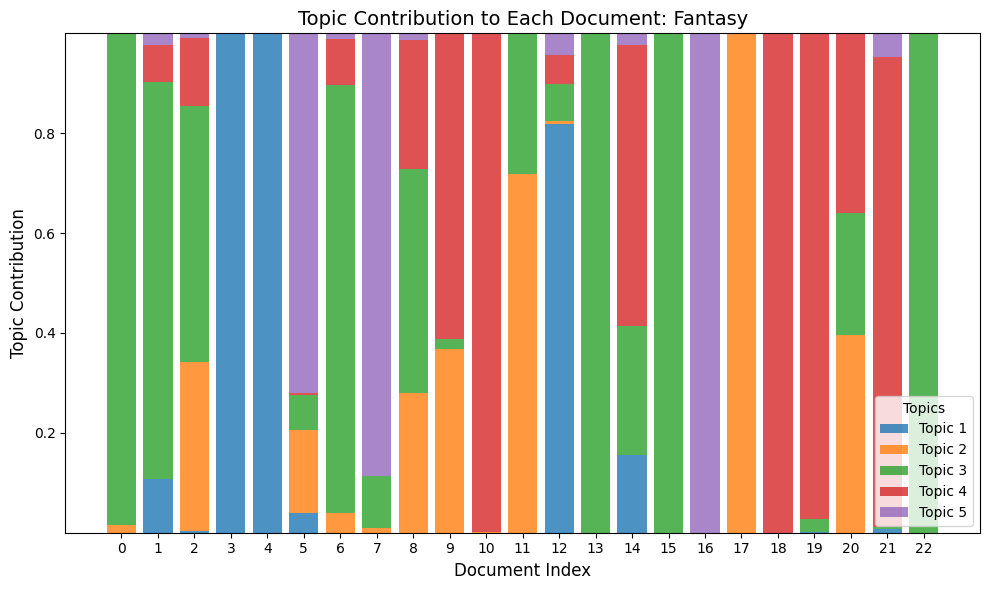


--- Topics for Genre: Historical_Fiction ---
Topic 1:
man said like little marius did jean valjean time men
Topic 2:
said artagnan athos monsieur porthos man aramis king yes cardinal
Topic 3:
said mr little man good miss great time like old
Topic 4:
said thou thee man thy time shall sir like good
Topic 5:
said did man prince like know pierre come time thought

              Topic 1   Topic 2   Topic 3   Topic 4   Topic 5
Document 1   0.231957  0.009187  0.757626  0.000954  0.000276
Document 2   0.000003  0.000003  0.223488  0.014055  0.762450
Document 3   0.010802  0.000003  0.972321  0.016837  0.000038
Document 4   0.000325  0.000004  0.002971  0.996696  0.000004
Document 5   0.008017  0.000009  0.989281  0.002684  0.000010
Document 6   0.999762  0.000001  0.000160  0.000014  0.000062
Document 7   0.000002  0.000002  0.244953  0.000002  0.755040
Document 8   0.447559  0.014875  0.073062  0.206501  0.258003
Document 9   0.000003  0.000003  0.000003  0.999986  0.000003
Document 10  0.0

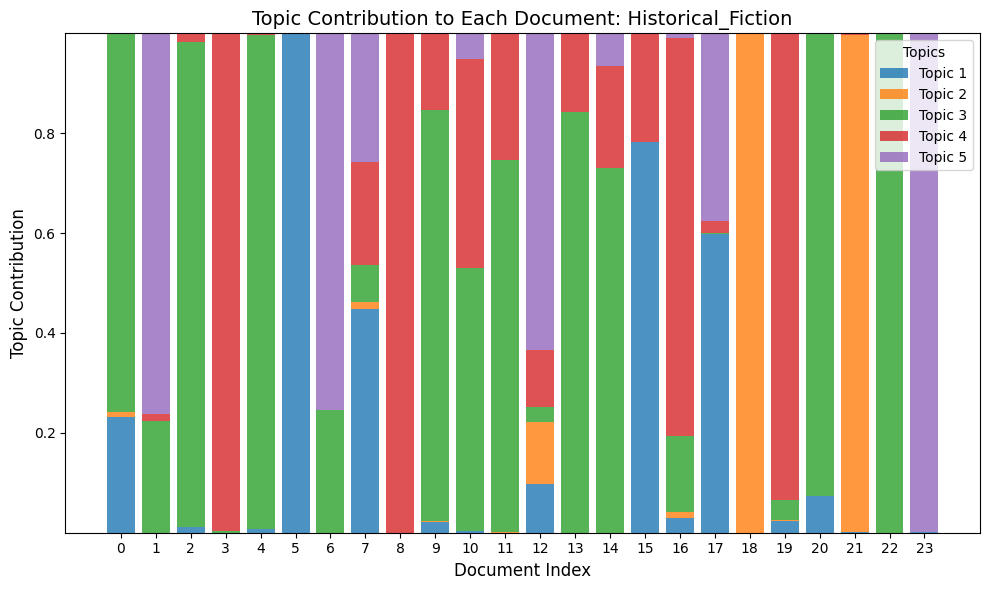


--- Topics for Genre: Mystery_Fiction ---
Topic 1:
mr said jasper rosa grewgious crisparkle little miss sir say
Topic 2:
mr said time franklin miss sergeant rachel house way lady
Topic 3:
said time little say great man long having did like
Topic 4:
mr said sir time verloc percival mrs man miss house
Topic 5:
said man like know time did come came good got

              Topic 1   Topic 2   Topic 3   Topic 4   Topic 5
Document 1   0.000005  0.000005  0.008682  0.000070  0.991239
Document 2   0.000008  0.000008  0.000019  0.000008  0.999957
Document 3   0.001121  0.038709  0.160493  0.025093  0.774584
Document 4   0.000003  0.997839  0.001327  0.000012  0.000819
Document 5   0.979510  0.000008  0.019230  0.000008  0.001244
Document 6   0.000008  0.000008  0.094639  0.767140  0.138206
Document 7   0.000019  0.003970  0.000153  0.001992  0.993866
Document 8   0.000003  0.000003  0.001591  0.998337  0.000066
Document 9   0.000010  0.000010  0.999962  0.000010  0.000010
Document 10  0.000009

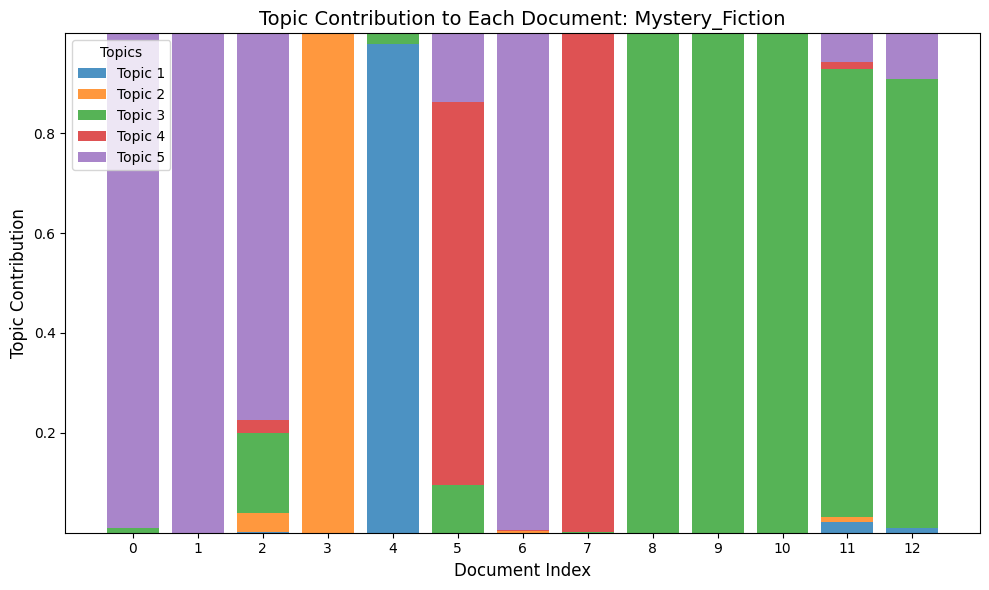


--- Topics for Genre: Philosophy ---
Topic 1:
thou man zarathustra ye did hath men good great like
Topic 2:
mind things nature man far social knowledge body god thing
Topic 3:
idea nature mind object objects government power ideas reason human
Topic 4:
reason conception experience object time pure conceptions understanding possible intuition
Topic 5:
man good said state men true say life like things

              Topic 1   Topic 2   Topic 3   Topic 4   Topic 5
Document 1   0.000003  0.000003  0.999988  0.000003  0.000003
Document 2   0.000865  0.013204  0.919844  0.030311  0.035777
Document 3   0.111188  0.000056  0.000056  0.000057  0.888644
Document 4   0.514635  0.141116  0.103289  0.037138  0.203823
Document 5   0.000008  0.315193  0.460660  0.000008  0.224130
Document 6   0.000005  0.982689  0.000564  0.009199  0.007543
Document 7   0.029420  0.004304  0.804217  0.032778  0.129281
Document 8   0.106635  0.131163  0.428715  0.055645  0.277841
Document 9   0.000007  0.988125  0.01

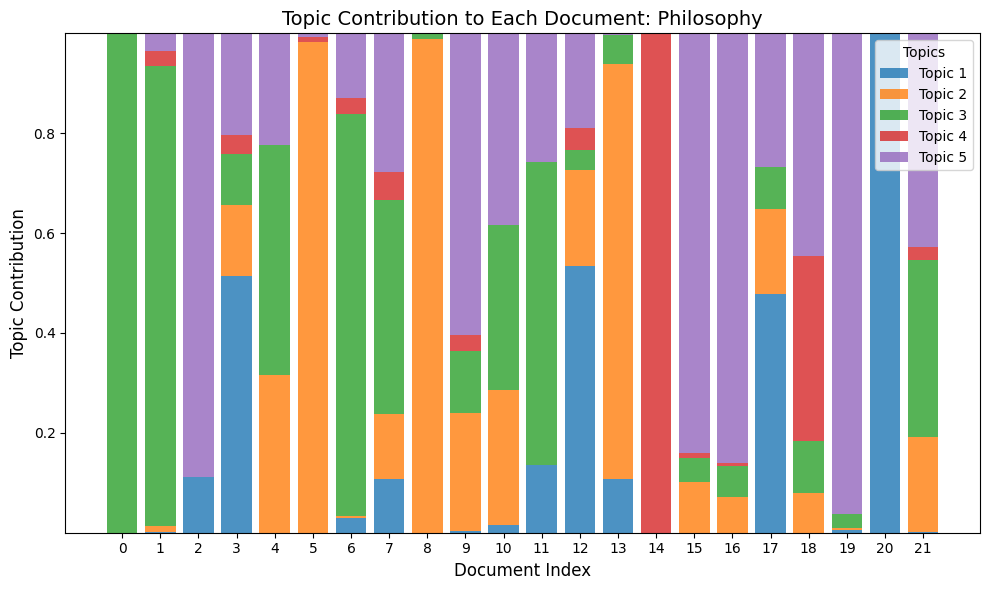


--- Topics for Genre: Science_Fiction ---
Topic 1:
pencroft harding island said herbert cyrus engineer replied uncle neb
Topic 2:
captain nemo sea ned conseil nautilus land said like _nautilus_
Topic 3:
said man little came like time saw went did way
Topic 4:
said kennon alexander ll like lani know don man hendricks
Topic 5:
great men dejah shall thoris know little did time women

              Topic 1   Topic 2   Topic 3   Topic 4   Topic 5
Document 1   0.000292  0.000293  0.152496  0.846624  0.000294
Document 2   0.682653  0.014622  0.255039  0.000008  0.047677
Document 3   0.000012  0.000012  0.002281  0.000012  0.997684
Document 4   0.000041  0.000040  0.436699  0.000040  0.563180
Document 5   0.000027  0.000027  0.040698  0.000027  0.959222
Document 6   0.000043  0.000043  0.051091  0.948780  0.000043
Document 7   0.000234  0.000235  0.415559  0.508712  0.075259
Document 8   0.000005  0.000005  0.999981  0.000005  0.000005
Document 9   0.000638  0.000639  0.664317  0.333765  0.00

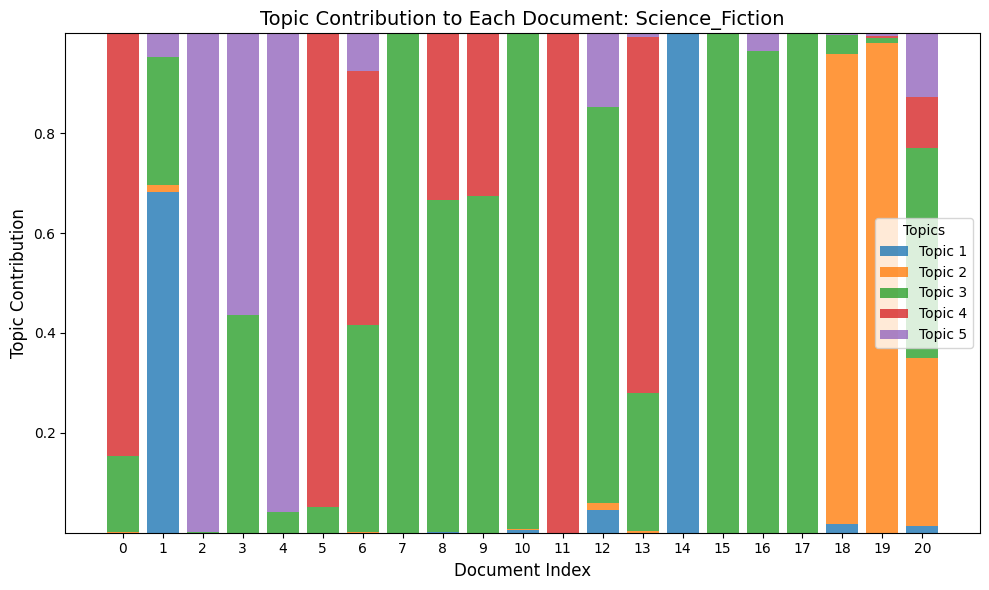

In [14]:
import matplotlib.pyplot as plt
import numpy as np
for genre_folder in os.listdir(base_dir):
    genre_path = os.path.join(base_dir, genre_folder, 'cleaned')
    if not os.path.exists(genre_path):
        continue

    # Collect texts for the current genre
    book_texts = []
    for filename in os.listdir(genre_path):
        if filename.endswith('.txt'):
            with open(os.path.join(genre_path, filename), 'r', encoding='utf-8') as f:
                book_texts.append(f.read())


    # Vectorize the text using CountVectorizer
    vectorizer = CountVectorizer(max_features=2000, stop_words='english')
    X = vectorizer.fit_transform(book_texts)

    # Apply LDA
    lda = LatentDirichletAllocation(n_components=5, random_state=42)  
    lda.fit(X)

    # Display the topics for the current genre
    print(f"\n--- Topics for Genre: {genre_folder} ---")
    words = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([words[i] for i in topic.argsort()[-10:][::-1]]))

    # Get the topic contribution for each document
    doc_topic_distr = lda.transform(X)

    # Format and print as a table
    topic_labels = [f"Topic {i + 1}" for i in range(5)]
    doc_indices = [f"Document {i + 1}" for i in range(len(book_texts))]
    doc_topic_df = pd.DataFrame(doc_topic_distr, columns=topic_labels, index=doc_indices)
    print()
    print(doc_topic_df)

    # Plot topic contributions for each document in this genre
    fig, ax = plt.subplots(figsize=(10, 6))
    for topic_idx in range(5):  # Assuming 5 topics
        ax.bar(
            range(len(book_texts)),
            doc_topic_distr[:, topic_idx],
            bottom=np.sum(doc_topic_distr[:, :topic_idx], axis=1),
            label=f"Topic {topic_idx + 1}",
            alpha=0.8
        )

    ax.set_title(f"Topic Contribution to Each Document: {genre_folder}", fontsize=14)
    ax.set_xlabel("Document Index", fontsize=12)
    ax.set_ylabel("Topic Contribution", fontsize=12)
    ax.set_xticks(range(len(book_texts)))
    ax.legend(title="Topics")
    plt.tight_layout()
    plt.show()




In [15]:
all_genres_contributions = []

for genre_folder in os.listdir(base_dir):
    genre_path = os.path.join(base_dir, genre_folder, 'cleaned')
    if not os.path.exists(genre_path):
        continue

    # Collect texts for the current genre
    book_texts = []
    for filename in os.listdir(genre_path):
        if filename.endswith('.txt'):
            with open(os.path.join(genre_path, filename), 'r', encoding='utf-8') as f:
                book_texts.append(f.read())

    if not book_texts:  # Skip genres with no books
        print(f"No texts found for genre: {genre_folder}")
        continue

    # Vectorize the text using CountVectorizer
    vectorizer = CountVectorizer(max_features=2000, stop_words='english')
    X = vectorizer.fit_transform(book_texts)

    # Apply LDA
    lda = LatentDirichletAllocation(n_components=5, random_state=42)  # 5 topics
    lda.fit(X)

    # Get the topic contribution 
    doc_topic_distr = lda.transform(X)

    # Compute the average topic contributions 
    avg_topic_contributions = doc_topic_distr.mean(axis=0)

    # Append the contributions for this genre
    all_genres_contributions.append([genre_folder] + avg_topic_contributions.tolist())

# Create a DataFrame 
columns = ["Genre"] + [f"Topic {i + 1}" for i in range(5)]
final_df = pd.DataFrame(all_genres_contributions, columns=columns)
#the average Topic Contributions
print("\n Topic Contributions Across Genres:")
print(final_df)




 Topic Contributions Across Genres:
                Genre   Topic 1   Topic 2   Topic 3   Topic 4   Topic 5
0             Fantasy  0.136190  0.145150  0.333775  0.263976  0.120909
1  Historical_Fiction  0.138988  0.089761  0.378493  0.229770  0.162988
2     Mystery_Fiction  0.077796  0.080808  0.390892  0.138950  0.311554
3          Philosophy  0.138456  0.214688  0.252922  0.075269  0.318664
4     Science_Fiction  0.084161  0.109206  0.437364  0.227627  0.141641



--- Word Clouds for Genre: Fantasy ---


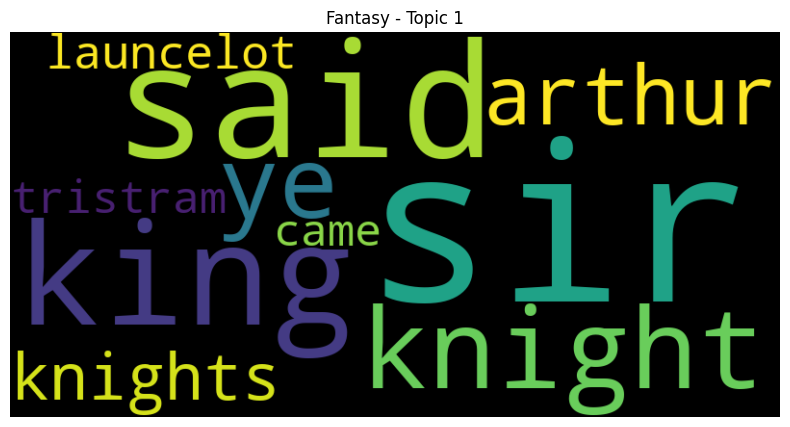

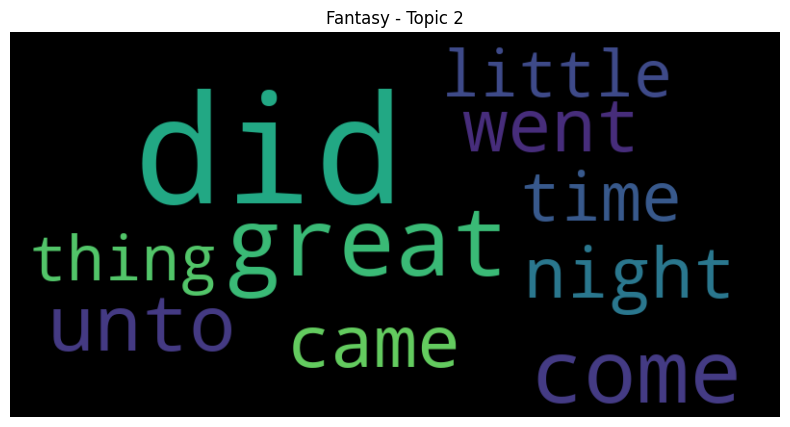

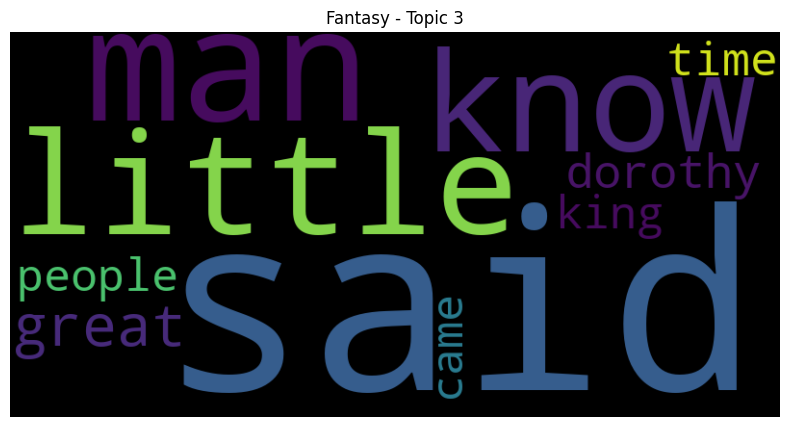

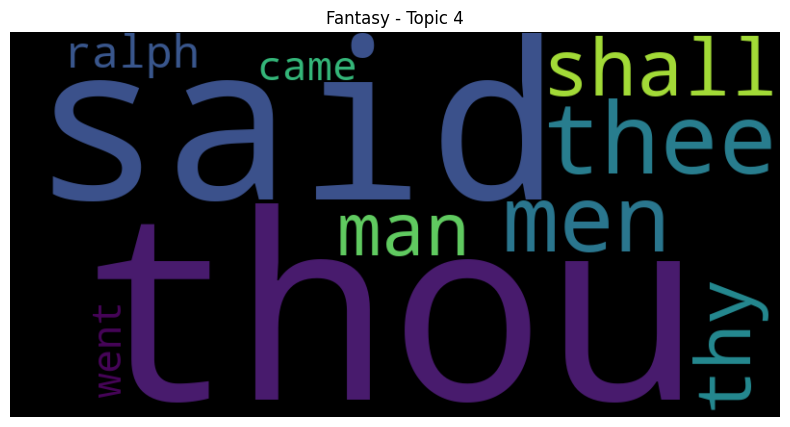

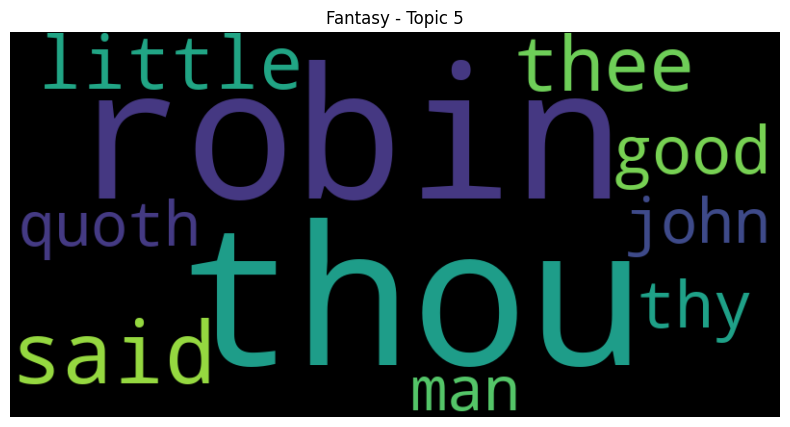


--- Word Clouds for Genre: Historical_Fiction ---


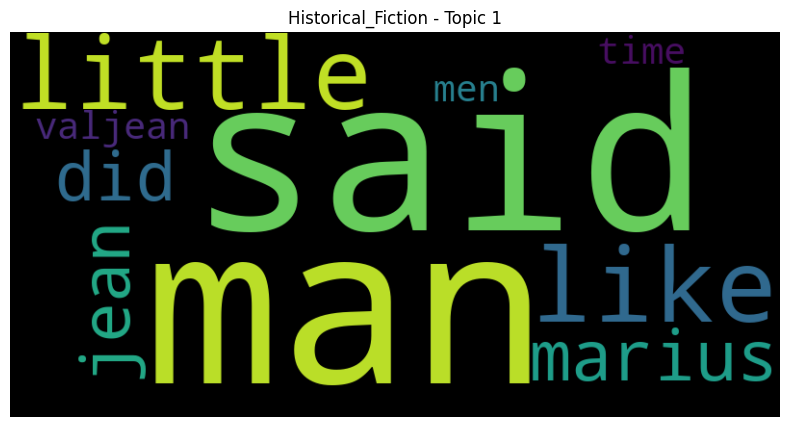

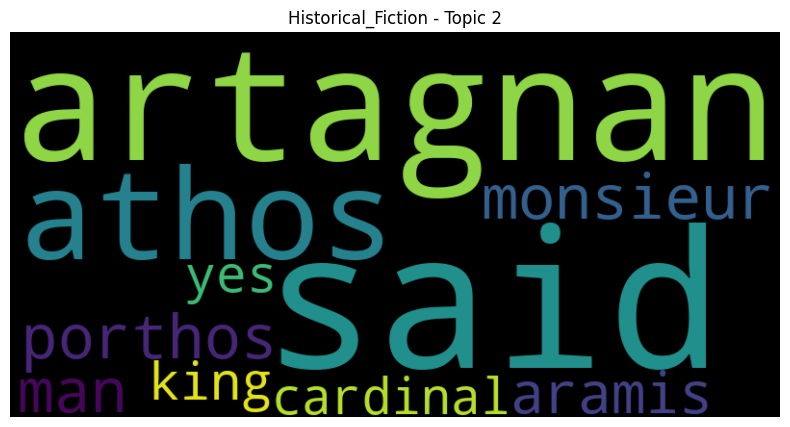

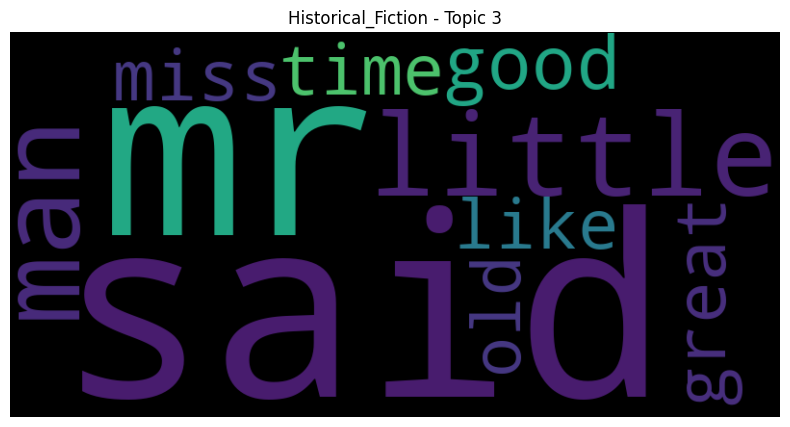

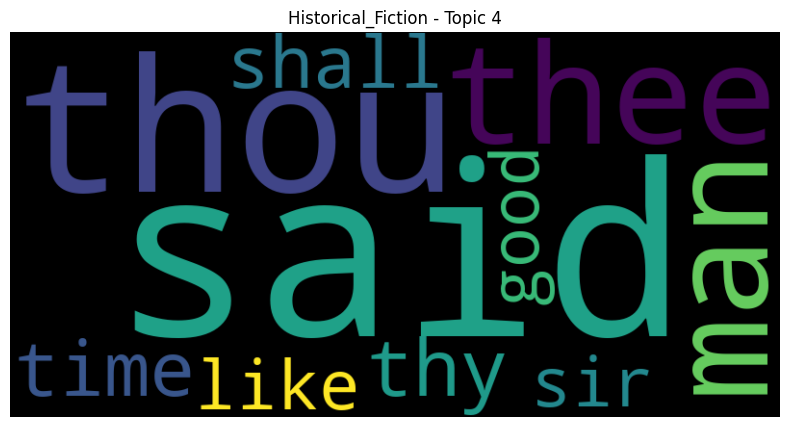

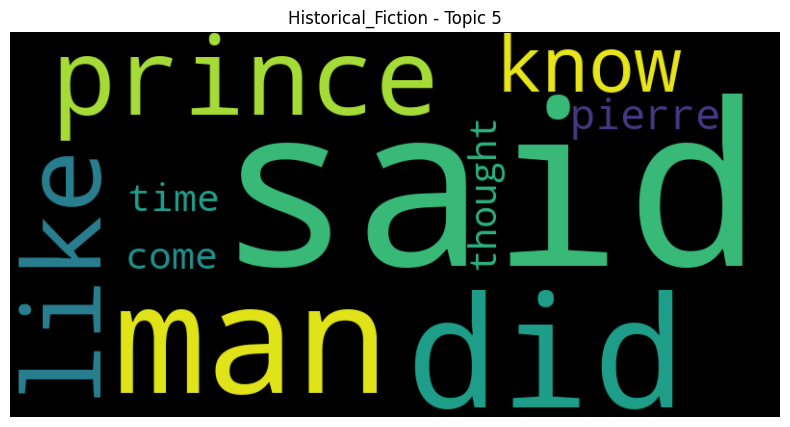


--- Word Clouds for Genre: Mystery_Fiction ---


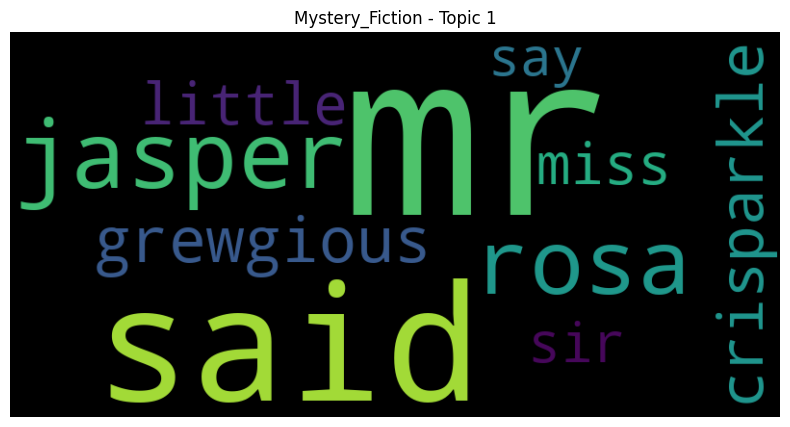

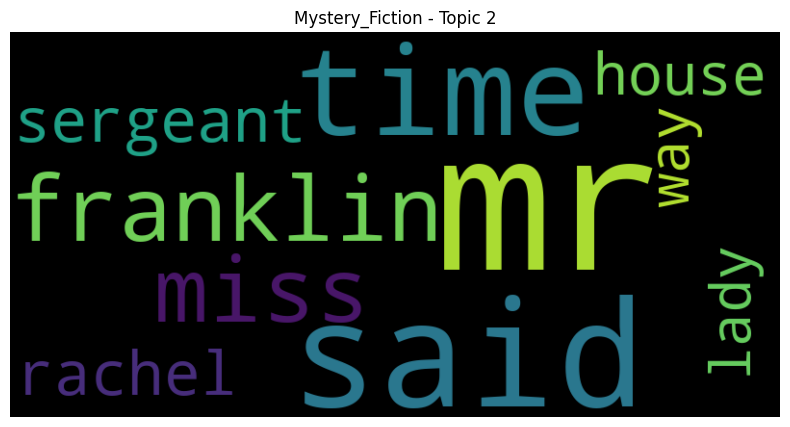

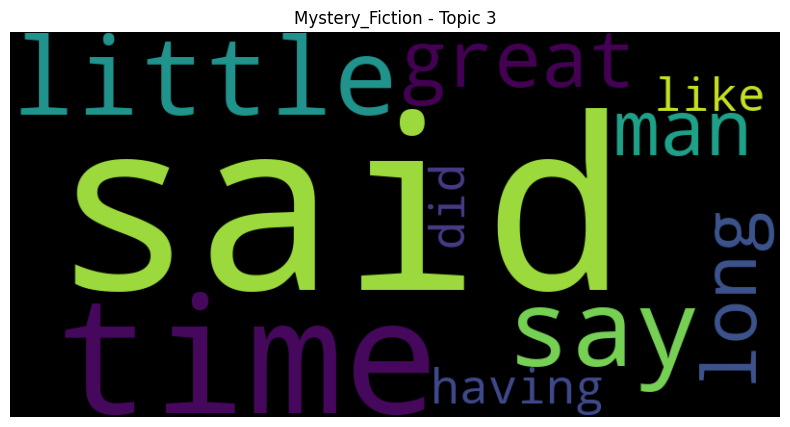

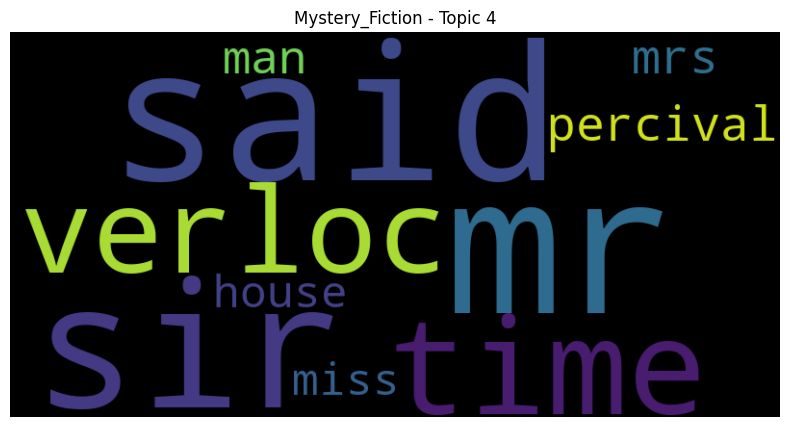

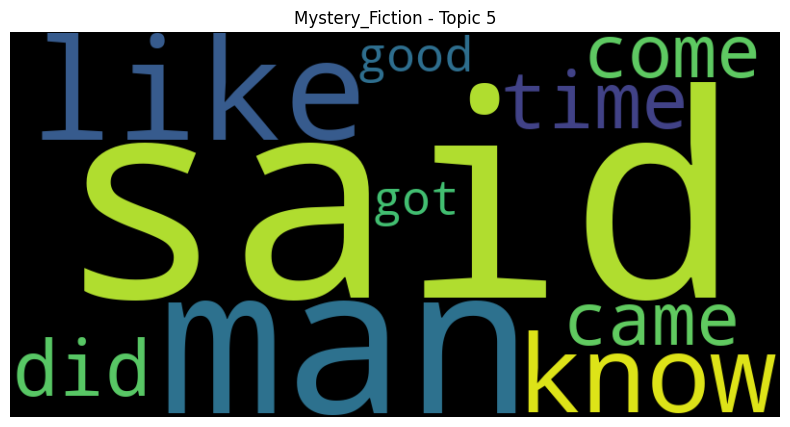


--- Word Clouds for Genre: Philosophy ---


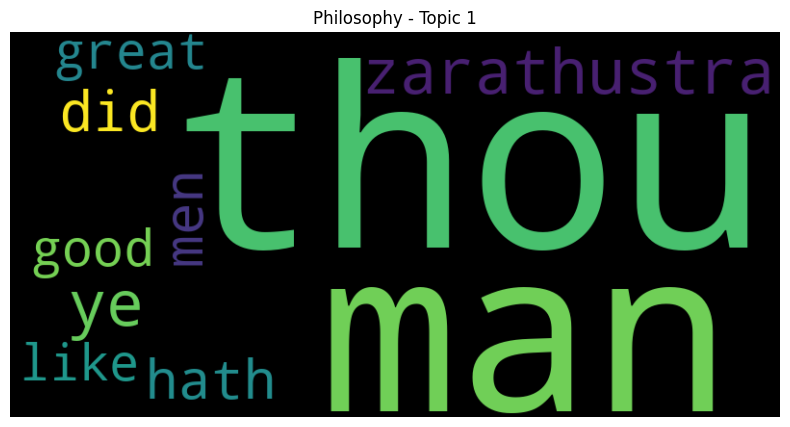

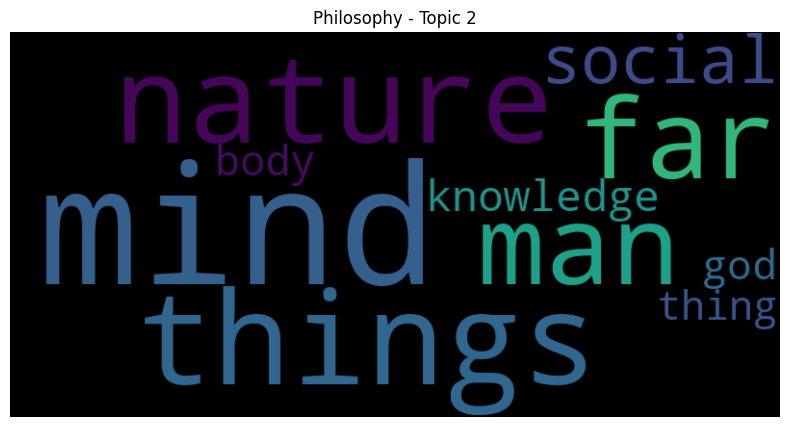

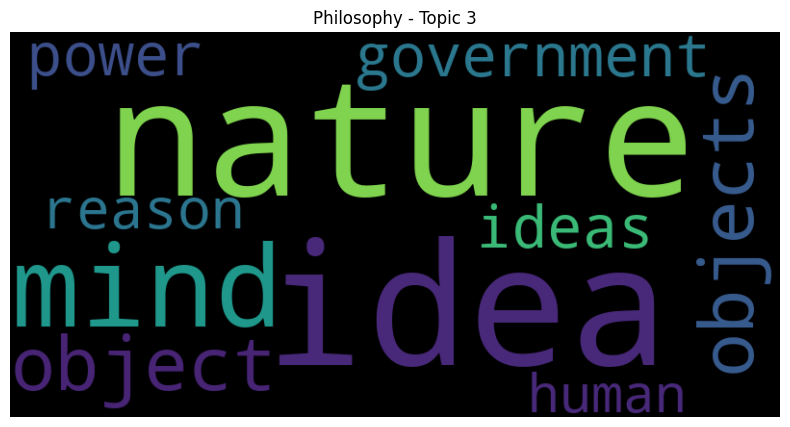

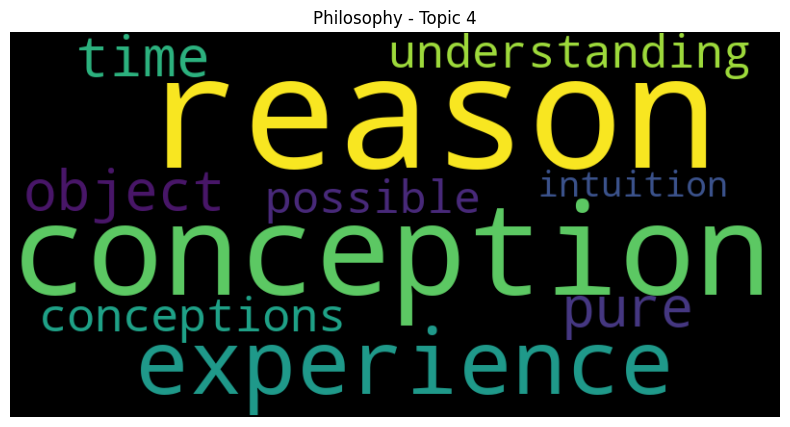

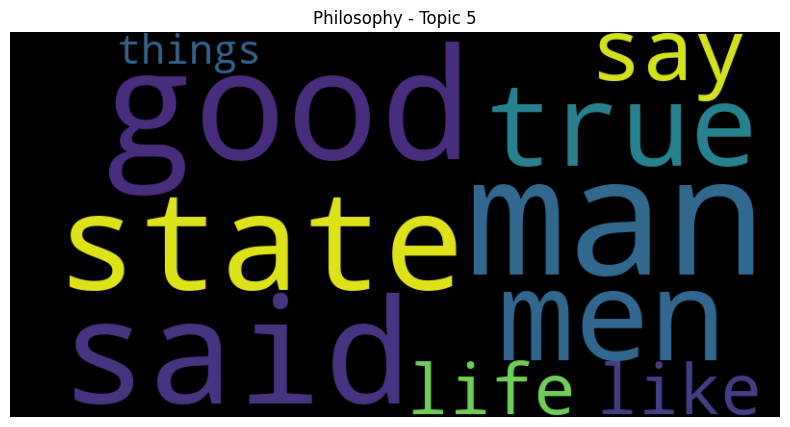


--- Word Clouds for Genre: Science_Fiction ---


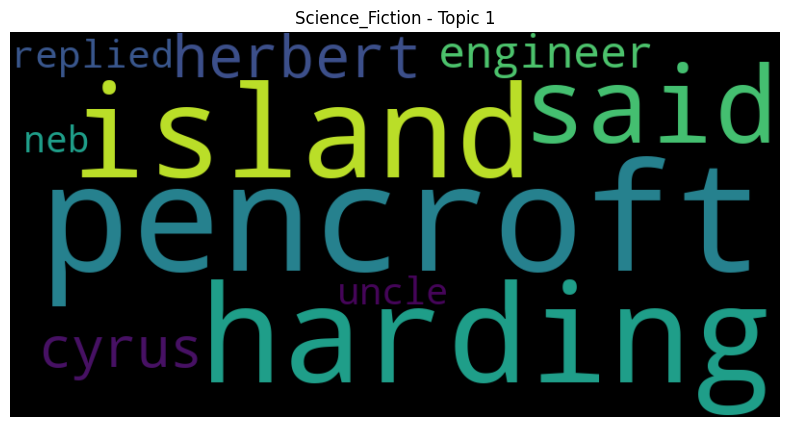

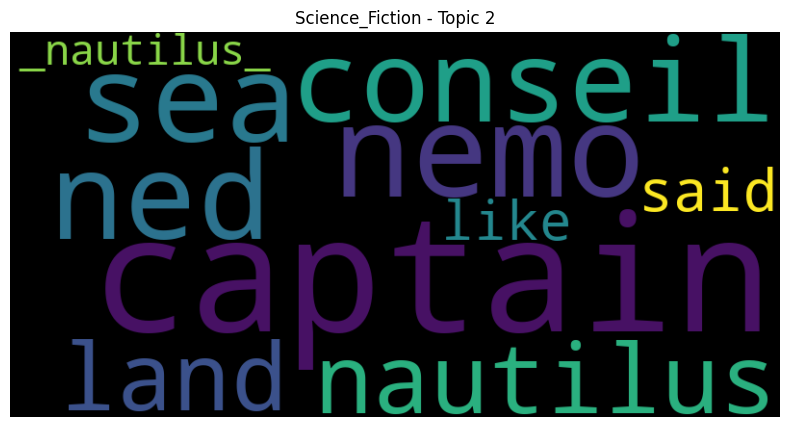

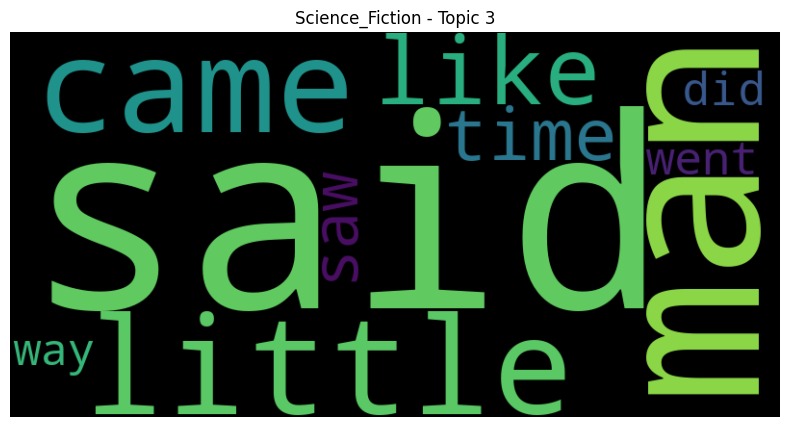

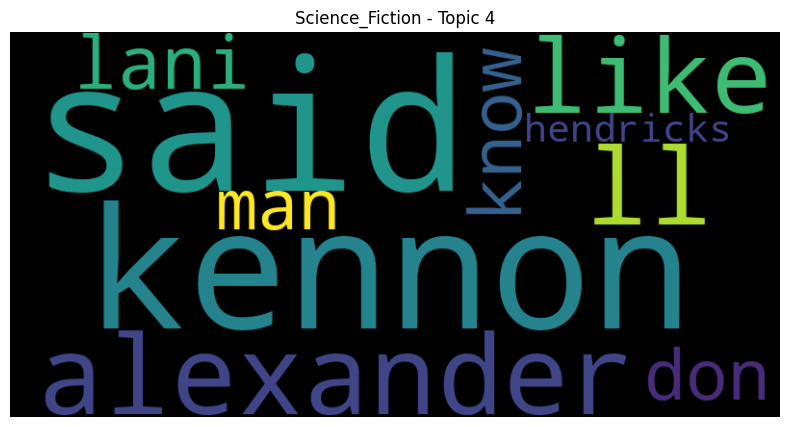

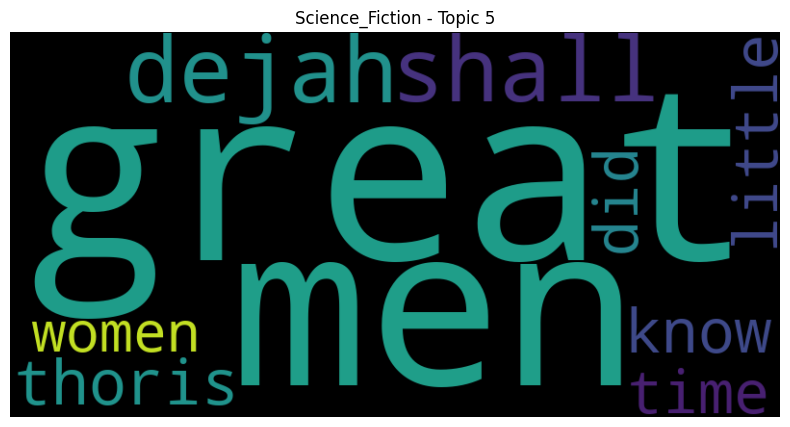

In [17]:
from wordcloud import WordCloud
for genre_folder in os.listdir(base_dir):
    genre_path = os.path.join(base_dir, genre_folder, 'cleaned')
    if not os.path.exists(genre_path):
        continue

    # Collect texts for the current genre
    book_texts = []
    for filename in os.listdir(genre_path):
        if filename.endswith('.txt'):
            with open(os.path.join(genre_path, filename), 'r', encoding='utf-8') as f:
                book_texts.append(f.read())

    if not book_texts:  # Skip genres with no books
        print(f"No texts found for genre: {genre_folder}")
        continue

    # Vectorize the text using CountVectorizer
    vectorizer = CountVectorizer(max_features=2000, stop_words='english')
    X = vectorizer.fit_transform(book_texts)

    # Apply LDA
    lda = LatentDirichletAllocation(n_components=5, random_state=42)  # 5 topics
    lda.fit(X)

    # Generate word clouds for the current genre
    print(f"\n--- Word Clouds for Genre: {genre_folder} ---")
    words = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda.components_):
        topic_words = {words[i]: topic[i] for i in topic.argsort()[-10:]}  # Top 10 words
        wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(topic_words)
        
        # Display the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"{genre_folder} - Topic {topic_idx + 1}")
        plt.show()
